In [2]:
import time

from ib.opt import message
import numpy as np
import pandas as pd

import contracts
from settings import TWS_CONNECTION, company

In [42]:
class GetPutCallPrices():
    contract = None
    right = None
    prices_put = pd.DataFrame()
    prices_call = pd.DataFrame()
    prices_msg = pd.DataFrame()
    wait = 0.1
    
    def __init__(self, company, expiration, strike):
        self.company = company
        self.expiration = expiration
        self.strike = strike

    def get_prices(self):
        TWS_CONNECTION.register(self.msg_handler, message.historicalData)
        TWS_CONNECTION.register(self.error_handler, message.Error)
#         TWS_CONNECTION.registerAll(print)
        self.get_put_prices()
        prices_put = self.prices_msg
        self.prices_msg = pd.DataFrame()
        self.get_call_prices()
        prices_call = self.prices_msg
        # Merge PUT & CALL into one DateFrame
        return prices_call.join(prices_put)
       
    def get_put_prices(self):
        self.right = 'P' # for the column name
        self.contract = contracts.PutOption(
            self.company,
            self.expiration,
            self.strike
        )
        self.request_prices()

    def get_call_prices(self):
        self.right = 'C' # for the column name
        self.contract = contracts.CallOption(
            self.company,
            self.expiration,
            self.strike
        )
        self.request_prices()
 
    def request_prices(self):
        TWS_CONNECTION.connect()
        TWS_CONNECTION.reqHistoricalData(
            1,
            self.contract,
            '',
            '1 W',
            '30 mins',
            "TRADES",
            1,
            1
        )
        while self.wait and self.wait < 10:
            time.sleep(0.1)
            self.wait += 0.1
        self.wait = 0.1
        TWS_CONNECTION.disconnect()
        
    def msg_handler(self, msg):
        """
        Function get message from TWS and put it into pandas DataFrame object
        :param msg: message from TWS
        :return: dataframe w/ historical prices
        """
        if 'finished' in msg.date:
            self.wait = False
            return None
        columns = pd.MultiIndex.from_product([[self.right], [self.expiration], [self.strike]])
        new_row = pd.DataFrame(msg.close, index=[msg.date], columns=columns)
        self.prices_msg = self.prices_msg.append(new_row)
    
    def error_handler(self, msg):
        print(type(msg), msg)
        if msg.errorCode == 200:
            self.wait = False

In [100]:
index = ['Right', 'Expiration', 'Strike']
a = {
    'Datetime': '20191127  21:30:00',
    'Right': 'P',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 0.37
}
b = {
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 300.,
    '20191127  21:30:00': 1.37
}
test = pd.DataFrame()

columns = pd.MultiIndex.from_product([[a['Right']], [a['Expiration']], [a['Strike']]])
a = pd.DataFrame(a['Price'], index=[a['Datetime']], columns=columns)
# a = pd.DataFrame(a, index=['Datetime'], columns='Price')# = [0]).set_index(['Right', 'Expiration', 'Strike'])
print(a)
b = pd.DataFrame(b, index = [0]).set_index(['Right', 'Expiration', 'Strike'])
# b
# test = test.append(a)
# test = test.append(b)
# # print(test)
# c = {
#     'Right': 'C',
#     'Expiration': '20191206',
#     'Strike': 300.,
#     '20191128  21:30:00': 5.23    # at the next day
# }
# c = pd.DataFrame(c, index = [0]).set_index(['Right', 'Expiration', 'Strike'])
# test = pd.concat([test, c], axis=1, sort=False)
# d = pd.DataFrame()
# test = pd.concat([test, d], axis=1, sort=False)
# e = {
#     'Right': 'C',
#     'Expiration': '20191206',
#     'Strike': 305,    # new strike
#     '20191128  21:30:00': 5.23
# }
# e = pd.DataFrame(e, index = [0]).set_index(['Right', 'Expiration', 'Strike'])
# test = pd.concat([test, e], axis=1, sort=False)
# print(test)

                          P
                   20191206
                      300.0
20191127  21:30:00     0.37


In [101]:
a = {
    'Datetime': '20191127  21:30:00',
    'Right': 'P',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 0.37
}
b = {
    'Datetime': '20191127  21:30:00',
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 5.3
}
test = pd.DataFrame()

columns = pd.MultiIndex.from_product([[a['Right']], [a['Expiration']], [a['Strike']]])
a = pd.DataFrame(a['Price'], index=[a['Datetime']], columns=columns)
# print(a)
test = test.append(a)
columns = pd.MultiIndex.from_product([[b['Right']], [b['Expiration']], [b['Strike']]])
b = pd.DataFrame(b['Price'], index=[b['Datetime']], columns=columns)
# print(b)
test = test.append(b)
# print(test)

c = {
    'Datetime': '20191128  21:30:00', # new
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 300.,
    'Price': 16.3
}
columns = pd.MultiIndex.from_product([[c['Right']], [c['Expiration']], [c['Strike']]])
c = pd.DataFrame(c['Price'], index=[c['Datetime']], columns=columns)
test = test.append(c)

d = {
    'Datetime': '20191128  21:30:00',
    'Right': 'C',
    'Expiration': '20191206',
    'Strike': 305.,    # new
    'Price': 9.5
}
columns = pd.MultiIndex.from_product([[d['Right']], [d['Expiration']], [d['Strike']]])
d = pd.DataFrame(d['Price'], index=[d['Datetime']], columns=columns)
# test = pd.concat([test, d], axis=0, sort=False)



test = test.join(d, how='outer')
test





,C,P,C
,20191206,20191206,20191206
,300.0,300.0,305.0
20191127 21:30:00,NaN,0.37,NaN
20191127 21:30:00,5.3,NaN,NaN
20191128 21:30:00,16.3,NaN,9.5


In [41]:
prices = GetPutCallPrices(
    company,
    '20191206',   # 20220121
    100   # 420
).get_prices()
prices.index = pd.to_datetime(prices.index)
prices = prices.groupby(pd.Grouper(freq='D')).nth(-1) # convert to 1D timeframe

<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [27]:
prices

,C,P
,20191206,20191206
,300,300
2019-11-25,38.95,0.42
2019-11-26,28.65,0.48
2019-11-27,30.15,0.29
2019-11-29,30.20,0.30


In [36]:
%matplotlib inline
import matplotlib.pyplot as plt

import logging
mpl_logger = logging.getLogger('matplotlib') 
mpl_logger.setLevel(logging.ERROR)

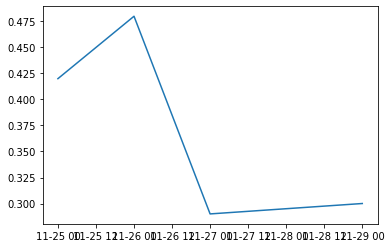

In [38]:
plt.plot(prices['P'])
plt.show()

In [7]:
# Look for all strikes and expirations
from ib.ext.ContractDetails import ContractDetails
from ib.ext.EClientSocket import EClientSocket


def get_option_chain():
    contract = contracts.CallOption(
        company,
        None,
        None
    )
    options = []
    wait = 0.1

    def msg_stopper(msg):
        wait = False
        
    def msg_handler(msg):
        options.append({
            'strike': msg.contractDetails.m_summary.m_strike,
            'expiration': msg.contractDetails.m_summary.m_expiry
        })

#     TWS_CONNECTION.registerAll(print)
    TWS_CONNECTION.register(msg_handler, 'ContractDetails')
    TWS_CONNECTION.register(msg_stopper, 'ContractDetailsEnd')
    TWS_CONNECTION.connect()
    EClientSocket.reqContractDetails(TWS_CONNECTION, 1, contract)
    while wait and wait < 10:
        time.sleep(0.1)
        wait += 0.1
    TWS_CONNECTION.disconnect()
    return options

In [8]:
options = get_option_chain()

<managedAccounts accountsList=U2296624>
<nextValidId orderId=1>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<error id=-1, errorCode=2106, errorMsg=HMDS data farm connection is OK:ushmds>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<class 'ib.opt.message.Error'> <error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<error id=-1, errorCode=2158, errorMsg=Sec-def data farm connection is OK:secdefeu>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f940>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f940>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f940>>
<cont

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111aabf28>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e60f390>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x111ceb550>>
<contractDetails reqId=1, contractDetails=<ib.

<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.ext.ContractDetails.ContractDetails object at 0x11e8c8fd0>>
<contractDetails reqId=1, contractDetails=<ib.

In [9]:
options

[{'strike': 175.0, 'expiration': '20200117'},
 {'strike': 180.0, 'expiration': '20200117'},
 {'strike': 185.0, 'expiration': '20200117'},
 {'strike': 190.0, 'expiration': '20200117'},
 {'strike': 195.0, 'expiration': '20200117'},
 {'strike': 200.0, 'expiration': '20200117'},
 {'strike': 210.0, 'expiration': '20200117'},
 {'strike': 220.0, 'expiration': '20200117'},
 {'strike': 230.0, 'expiration': '20200117'},
 {'strike': 240.0, 'expiration': '20200117'},
 {'strike': 250.0, 'expiration': '20200117'},
 {'strike': 255.0, 'expiration': '20200117'},
 {'strike': 260.0, 'expiration': '20200117'},
 {'strike': 265.0, 'expiration': '20200117'},
 {'strike': 270.0, 'expiration': '20200117'},
 {'strike': 275.0, 'expiration': '20200117'},
 {'strike': 280.0, 'expiration': '20200117'},
 {'strike': 285.0, 'expiration': '20200117'},
 {'strike': 290.0, 'expiration': '20200117'},
 {'strike': 295.0, 'expiration': '20200117'},
 {'strike': 300.0, 'expiration': '20200117'},
 {'strike': 305.0, 'expiration': '

In [66]:
from ib.opt import message
type(msgs[-1]) == message.contractDetailsEnd


True

In [ ]:
! git commit -a -m 'In work'
! git push

[version_2 ad64d59] In work
 2 files changed, 6594 insertions(+), 1439 deletions(-)
 rewrite .ipynb_checkpoints/test-checkpoint.ipynb (71%)
 rewrite test.ipynb (71%)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 4 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 20.04 KiB | 6.68 MiB/s, done.
Total 4 (delta 1), reused 0 (delta 0)
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
